Same as LinearSVC.ipynb but now with more MSA and PSP subjects in the datafile.  In addition, the datafile in combined so we need to add a function to combine groups ourselves.  No longer going to try to differentiate MSA and PSP.  Instead we will do 3 comparisons:
1. Control vs. All Park
1. PD vs. MSA/PSP
1. MSA vs. PD/PSP
1. PDP vs. PD/MSA

## Imports and Function Definitions

In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)

## 1. Control vs. PD/MSA/PSP

In [38]:
# Get the data
data1 = pd.read_excel('training_data.xlsx')
data1 = group_classes(data1, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=0.35, random_state=42)

In [39]:
classif = SVC(kernel='linear')

pipelines = []
pipelines.append(('SVC', classif))
pipelines.append(('Std', Pipeline([('Scaler', StandardScaler()),('SVC', classif)])))
pipelines.append(('Norm', Pipeline([('Norm', Normalizer()),('SVC', classif)])))
pipelines.append(('StdNorm', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('SVC', classif)])))
pipelines.append(('NormStd', Pipeline([('Norm', Normalizer()),('Scaler', StandardScaler()),('SVC', classif)])))


#PCA
pipelines.append(('PCA45', Pipeline([('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdPCA45', Pipeline([('Scaler', StandardScaler()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdNormPCA45', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('NormStdPCA45', Pipeline([('Norm', Normalizer()),('Scaler', StandardScaler()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('NormPCA45Std', Pipeline([('Norm', Normalizer()),('PCA', PCA(n_components=45)),('Scaler', StandardScaler()),('SVC', classif)])))

#FSS
pipelines.append(('FSS45', Pipeline([('FSS', SelectKBest(k=45)),('SVC', classif)])))
pipelines.append(('StdFSSA45', Pipeline([('Scaler', StandardScaler()),('FSS', SelectKBest(k=45)),('SVC', classif)])))


pipelines.append(('StdNormFSS55', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('SVC', classif)])))
pipelines.append(('NormStdFSS45', Pipeline([('Norm', Normalizer()),('Scaler', StandardScaler()),('FSS', SelectKBest(k=55)),('SVC', classif)])))
pipelines.append(('NormFSS45Std', Pipeline([('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('Scaler', StandardScaler()),('SVC', classif)])))

pipelines.append(('StdNormFSS55PCA45', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdNormPCA45FSS55', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=45)),('FSS', SelectKBest(k=25)),('SVC', classif)])))



results = []
names = []
accs = []

for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train1, Y_train1, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    model.fit(X_train1, Y_train1)

    print("Holdout:")
    predictions = model.predict(X_test1)

    H_acc = accuracy_score(Y_test1, predictions)
    accs.append(H_acc)
    print(H_acc)
    print(confusion_matrix(Y_test1, predictions))
    print(classification_report(Y_test1, predictions))
    print()

SVC: 0.949689 (0.025970)
Holdout:
0.975155279503
[[ 93   2]
 [  6 221]]
             precision    recall  f1-score   support

          0       0.94      0.98      0.96        95
          1       0.99      0.97      0.98       227

avg / total       0.98      0.98      0.98       322


Std: 0.909520 (0.034980)
Holdout:
0.944099378882
[[ 85  10]
 [  8 219]]
             precision    recall  f1-score   support

          0       0.91      0.89      0.90        95
          1       0.96      0.96      0.96       227

avg / total       0.94      0.94      0.94       322


Norm: 0.948051 (0.031306)
Holdout:
0.972049689441
[[ 92   3]
 [  6 221]]
             precision    recall  f1-score   support

          0       0.94      0.97      0.95        95
          1       0.99      0.97      0.98       227

avg / total       0.97      0.97      0.97       322


StdNorm: 0.887740 (0.037931)
Holdout:
0.878881987578
[[ 67  28]
 [ 11 216]]
             precision    recall  f1-score   support

     

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


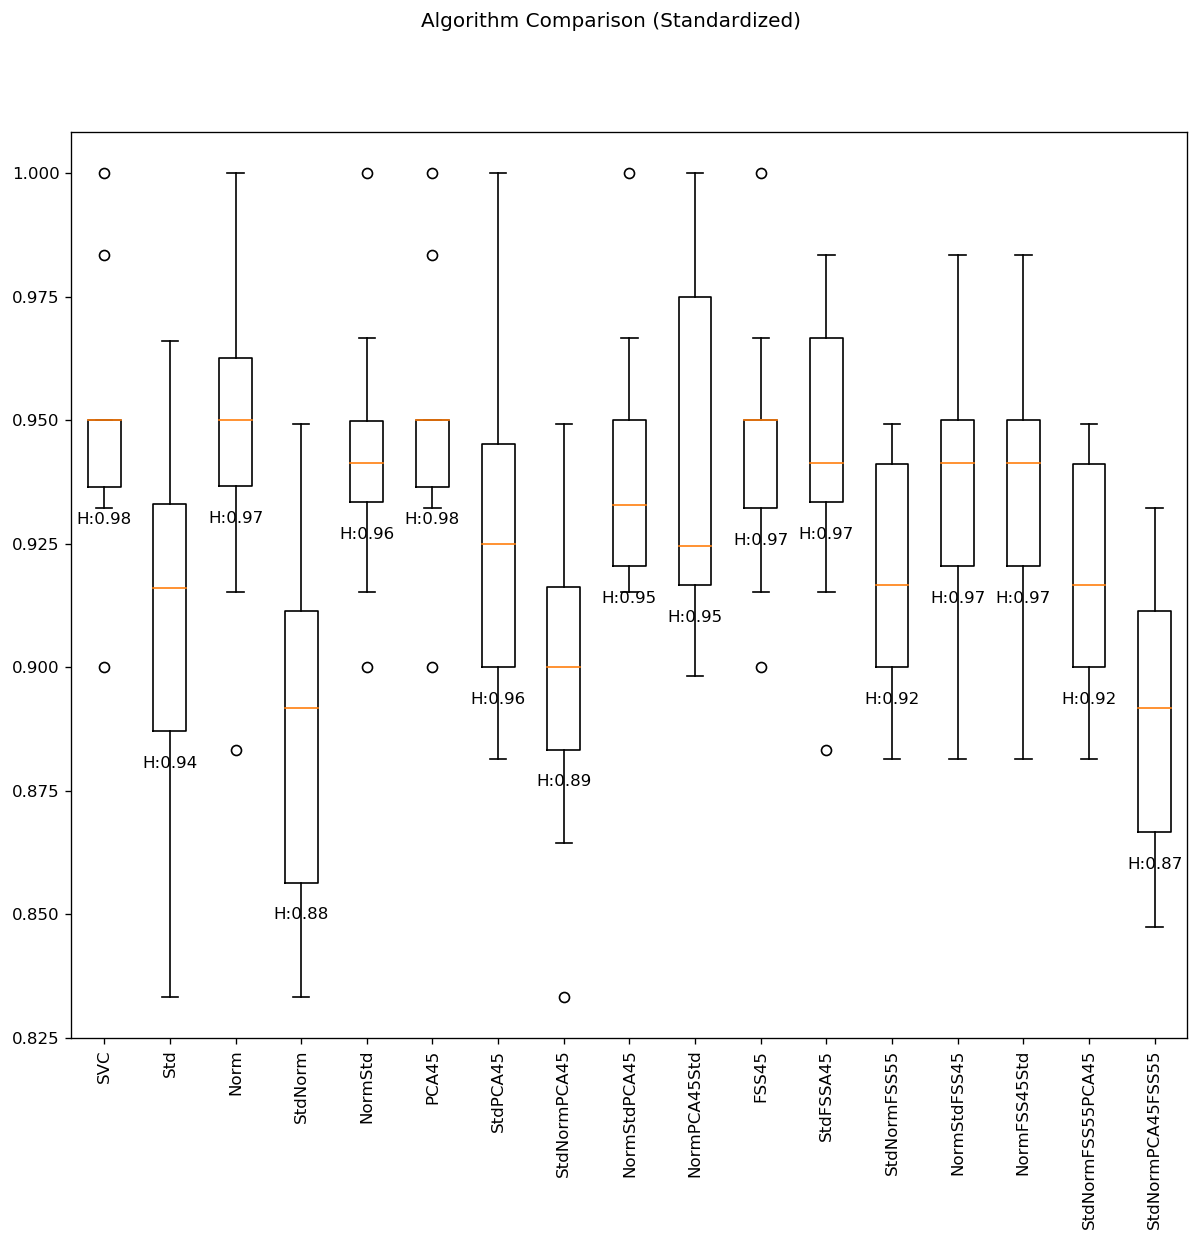

In [40]:
# Compare Algorithms
fig = plt.figure(figsize=(12, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
fig.suptitle('Algorithm Comparison (Standardized)')
ax = fig.add_subplot(111)
bp_dict = plt.boxplot(results)
ax.set_xticklabels(names)

for idx, line in enumerate(bp_dict['boxes']):
    x, y = line.get_xydata()[0] # bottom of left line
    plt.text(x+.25,y-0.005, 'H:%.2f' % accs[idx],
         horizontalalignment='center', # centered
         verticalalignment='top')
    
plt.show()

In [44]:
# parameters and ranges to plot
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
    #"PCA__n_components": range(1,115,10)
    "fss__k" : range(1,115,3)
}

clf = Pipeline([
    ('Norm', Normalizer()),
    ('Scaler', StandardScaler()),
    #("Oversample", RandomOverSampler()),
    #('PCA', PCA()),
    ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear'))
])

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=20, scoring='f1_micro')

# Tuning hyper-parameters for f1_micro

Fitting 20 folds for each of 760 candidates, totalling 15200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1235 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 3735 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 7235 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 11735 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 15185 out of 15200 | elapsed:  1.6min remaining:    0.0s


Best parameters set found on development set:

{'classifier__C': 2.3357214690901213, 'fss__k': 64}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.93      0.95      0.94        95
          1       0.98      0.97      0.97       227

avg / total       0.96      0.96      0.96       322




[Parallel(n_jobs=-1)]: Done 15200 out of 15200 | elapsed:  1.7min finished


In [45]:
best1.best_estimator_.fit(X_train1, Y_train1).score(X_test1, Y_test1)

0.96273291925465843

## 2. PD vs MSA/PSP

In [46]:
# Get the data
data2 = pd.read_excel('training_data.xlsx')
data2 = group_classes(data2, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=0.35, random_state=42)

In [47]:
classif = SVC(kernel='linear')

pipelines = []
pipelines.append(('SVC', classif))
pipelines.append(('Std', Pipeline([('Scaler', StandardScaler()),('SVC', classif)])))
pipelines.append(('Norm', Pipeline([('Norm', Normalizer()),('SVC', classif)])))
pipelines.append(('StdNorm', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('SVC', classif)])))

#PCA
pipelines.append(('PCA45', Pipeline([('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdPCA45', Pipeline([('Scaler', StandardScaler()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdNormPCA45', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('NormStdPCA45', Pipeline([('Norm', Normalizer()),('Scaler', StandardScaler()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('NormPCA45Std', Pipeline([('Norm', Normalizer()),('PCA', PCA(n_components=45)),('Scaler', StandardScaler()),('SVC', classif)])))

#FSS
pipelines.append(('FSS45', Pipeline([('FSS', SelectKBest(k=45)),('SVC', classif)])))
pipelines.append(('StdFSSA45', Pipeline([('Scaler', StandardScaler()),('FSS', SelectKBest(k=45)),('SVC', classif)])))


pipelines.append(('StdNormFSS55', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('SVC', classif)])))
pipelines.append(('NormStdFSS45', Pipeline([('Norm', Normalizer()),('Scaler', StandardScaler()),('FSS', SelectKBest(k=55)),('SVC', classif)])))
pipelines.append(('NormFSS45Std', Pipeline([('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('Scaler', StandardScaler()),('SVC', classif)])))

pipelines.append(('StdNormFSS55PCA45', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdNormPCA45FSS55', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=45)),('FSS', SelectKBest(k=25)),('SVC', classif)])))


results = []
names = []
accs = []

for name, model in pipelines:
    kfold = StratifiedKFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train2, Y_train2, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    model.fit(X_train2, Y_train2)

    print("Holdout:")
    predictions = model.predict(X_test2)

    H_acc = accuracy_score(Y_test2, predictions)
    accs.append(H_acc)
    print(H_acc)
    print(confusion_matrix(Y_test2, predictions))
    print(classification_report(Y_test2, predictions))
    print()

SVC: 0.872963 (0.033355)
Holdout:
0.917391304348
[[154  10]
 [  9  57]]
             precision    recall  f1-score   support

          0       0.94      0.94      0.94       164
          1       0.85      0.86      0.86        66

avg / total       0.92      0.92      0.92       230


Std: 0.849541 (0.041466)
Holdout:
0.865217391304
[[143  21]
 [ 10  56]]
             precision    recall  f1-score   support

          0       0.93      0.87      0.90       164
          1       0.73      0.85      0.78        66

avg / total       0.88      0.87      0.87       230


Norm: 0.651900 (0.013608)
Holdout:
0.713043478261
[[164   0]
 [ 66   0]]
             precision    recall  f1-score   support

          0       0.71      1.00      0.83       164
          1       0.00      0.00      0.00        66

avg / total       0.51      0.71      0.59       230


StdNorm: 0.889411 (0.046689)
Holdout:
0.895652173913
[[148  16]
 [  8  58]]
             precision    recall  f1-score   support

     

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PCA45: 0.877614 (0.027537)
Holdout:
0.926086956522
[[156   8]
 [  9  57]]
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       164
          1       0.88      0.86      0.87        66

avg / total       0.93      0.93      0.93       230


StdPCA45: 0.873187 (0.066416)
Holdout:
0.869565217391
[[145  19]
 [ 11  55]]
             precision    recall  f1-score   support

          0       0.93      0.88      0.91       164
          1       0.74      0.83      0.79        66

avg / total       0.88      0.87      0.87       230


StdNormPCA45: 0.879998 (0.033809)
Holdout:
0.891304347826
[[147  17]
 [  8  58]]
             precision    recall  f1-score   support

          0       0.95      0.90      0.92       164
          1       0.77      0.88      0.82        66

avg / total       0.90      0.89      0.89       230


NormStdPCA45: 0.880222 (0.040458)
Holdout:
0.878260869565
[[149  15]
 [ 13  53]]
             precision    recall  f1-sc

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

FSS45: 0.830715 (0.047032)
Holdout:
0.904347826087
[[151  13]
 [  9  57]]
             precision    recall  f1-score   support

          0       0.94      0.92      0.93       164
          1       0.81      0.86      0.84        66

avg / total       0.91      0.90      0.91       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

StdFSSA45: 0.861277 (0.068714)
Holdout:
0.865217391304
[[146  18]
 [ 13  53]]
             precision    recall  f1-score   support

          0       0.92      0.89      0.90       164
          1       0.75      0.80      0.77        66

avg / total       0.87      0.87      0.87       230


StdNormFSS55: 0.868206 (0.041129)
Holdout:
0.869565217391
[[146  18]
 [ 12  54]]
             precision    recall  f1-score   support

          0       0.92      0.89      0.91       164
          1       0.75      0.82      0.78        66

avg / total       0.87      0.87      0.87       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

NormStdFSS45: 0.854137 (0.035798)
Holdout:
0.882608695652
[[151  13]
 [ 14  52]]
             precision    recall  f1-score   support

          0       0.92      0.92      0.92       164
          1       0.80      0.79      0.79        66

avg / total       0.88      0.88      0.88       230


NormFSS45Std: 0.854137 (0.035798)


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

Holdout:
0.882608695652
[[151  13]
 [ 14  52]]
             precision    recall  f1-score   support

          0       0.92      0.92      0.92       164
          1       0.80      0.79      0.79        66

avg / total       0.88      0.88      0.88       230


StdNormFSS55PCA45: 0.868206 (0.041129)
Holdout:
0.869565217391
[[146  18]
 [ 12  54]]
             precision    recall  f1-score   support

          0       0.92      0.89      0.91       164
          1       0.75      0.82      0.78        66

avg / total       0.87      0.87      0.87       230


StdNormPCA45FSS55: 0.877672 (0.028974)
Holdout:
0.878260869565
[[146  18]
 [ 10  56]]
             precision    recall  f1-score   support

          0       0.94      0.89      0.91       164
          1       0.76      0.85      0.80        66

avg / total       0.88      0.88      0.88       230




In [53]:
# Compare Algorithms
fig = plt.figure(figsize=(12, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
bp_dict = plt.boxplot(results)
ax.set_xticklabels(names)

for idx, line in enumerate(bp_dict['boxes']):
    x, y = line.get_xydata()[0] # bottom of left line
    plt.text(x+.25,y-0.005, 'H:%.2f' % accs[idx],
         horizontalalignment='center', # centered
         verticalalignment='top')

plt.show()

<IPython.core.display.Javascript object>

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [83]:
# parameters and ranges to plot
param_grid = {
    "classifier__C": np.logspace(-5, 3, 100),
#     "classifier__class_weight": [{0: x, 1: 1.0-x} for x in np.linspace(0.05, 0.95, 20)]
#     "PCA__n_components": range(1,115,10)
#     "fss__k" : range(1,115,3)
}

clf = Pipeline([
    ('Norm', Normalizer()),
    ('Scaler', StandardScaler()),
    ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced'))
])

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=20, scoring='f1')

# Tuning hyper-parameters for f1

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 910 tasks      | elapsed:   14.5s


Best parameters set found on development set:

{'classifier__C': 0.19179102616724888}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.95      0.88      0.91       164
          1       0.74      0.88      0.81        66

avg / total       0.89      0.88      0.88       230




[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   38.7s finished


In [84]:
#Norm/Scalar/Oversample: 0.865217
#Norm/Scalar/Oversample/FSS: 0.878261
#Norm/Scalar/Oversample/PCA: 0.873913
#Norm/Scalra/Oversample: 0.882609

best2.best_estimator_.fit(X_train2, Y_train2).score(X_test2, Y_test2)

0.87391304347826082

## 3. MSA vs PD/PSP

In [22]:
# Get the data
data3 = pd.read_excel('training_data.xlsx')
data3 = group_classes(data3, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=0.35, random_state=42)

SVC: 0.865876 (0.010685)
Holdout:
0.926086956522
[[207   1]
 [ 16   6]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       208
          1       0.86      0.27      0.41        22

avg / total       0.92      0.93      0.91       230


Std: 0.856405 (0.046889)
Holdout:
0.882608695652
[[191  17]
 [ 10  12]]
             precision    recall  f1-score   support

          0       0.95      0.92      0.93       208
          1       0.41      0.55      0.47        22

avg / total       0.90      0.88      0.89       230


Norm: 0.856516 (0.005410)
Holdout:
0.904347826087
[[208   0]
 [ 22   0]]
             precision    recall  f1-score   support

          0       0.90      1.00      0.95       208
          1       0.00      0.00      0.00        22

avg / total       0.82      0.90      0.86       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


StdNorm: 0.898769 (0.018634)
Holdout:
0.930434782609
[[208   0]
 [ 16   6]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       208
          1       1.00      0.27      0.43        22

avg / total       0.94      0.93      0.91       230


PCA45: 0.870528 (0.016079)
Holdout:
0.926086956522
[[207   1]
 [ 16   6]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       208
          1       0.86      0.27      0.41        22

avg / total       0.92      0.93      0.91       230


StdPCA45: 0.894007 (0.035887)
Holdout:
0.94347826087
[[204   4]
 [  9  13]]
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       208
          1       0.76      0.59      0.67        22

avg / total       0.94      0.94      0.94       230


StdNormPCA45: 0.898769 (0.018634)
Holdout:
0.930434782609
[[208   0]
 [ 16   6]]
             precision    recall  f1-score   

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

FSS45: 0.856516 (0.005410)
Holdout:
0.913043478261
[[207   1]
 [ 19   3]]
             precision    recall  f1-score   support

          0       0.92      1.00      0.95       208
          1       0.75      0.14      0.23        22

avg / total       0.90      0.91      0.88       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

StdFSSA45: 0.889631 (0.030930)
Holdout:
0.930434782609
[[203   5]
 [ 11  11]]
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       208
          1       0.69      0.50      0.58        22

avg / total       0.92      0.93      0.93       230


StdNormFSS55: 0.884705 (0.016571)
Holdout:
0.926086956522
[[208   0]
 [ 17   5]]
             precision    recall  f1-score   support

          0       0.92      1.00      0.96       208
          1       1.00      0.23      0.37        22

avg / total       0.93      0.93      0.90       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

NormStdFSS45: 0.894118 (0.019043)
Holdout:
0.921739130435
[[205   3]
 [ 15   7]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       208
          1       0.70      0.32      0.44        22

avg / total       0.91      0.92      0.91       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

NormFSS45Std: 0.894118 (0.019043)
Holdout:
0.921739130435
[[205   3]
 [ 15   7]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       208
          1       0.70      0.32      0.44        22

avg / total       0.91      0.92      0.91       230


StdNormFSS55PCA45: 0.884705 (0.016571)
Holdout:
0.926086956522
[[208   0]
 [ 17   5]]
             precision    recall  f1-score   support

          0       0.92      1.00      0.96       208
          1       1.00      0.23      0.37        22

avg / total       0.93      0.93      0.90       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

StdNormPCA45FSS55: 0.891626 (0.024646)
Holdout:
0.930434782609
[[208   0]
 [ 16   6]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       208
          1       1.00      0.27      0.43        22

avg / total       0.94      0.93      0.91       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


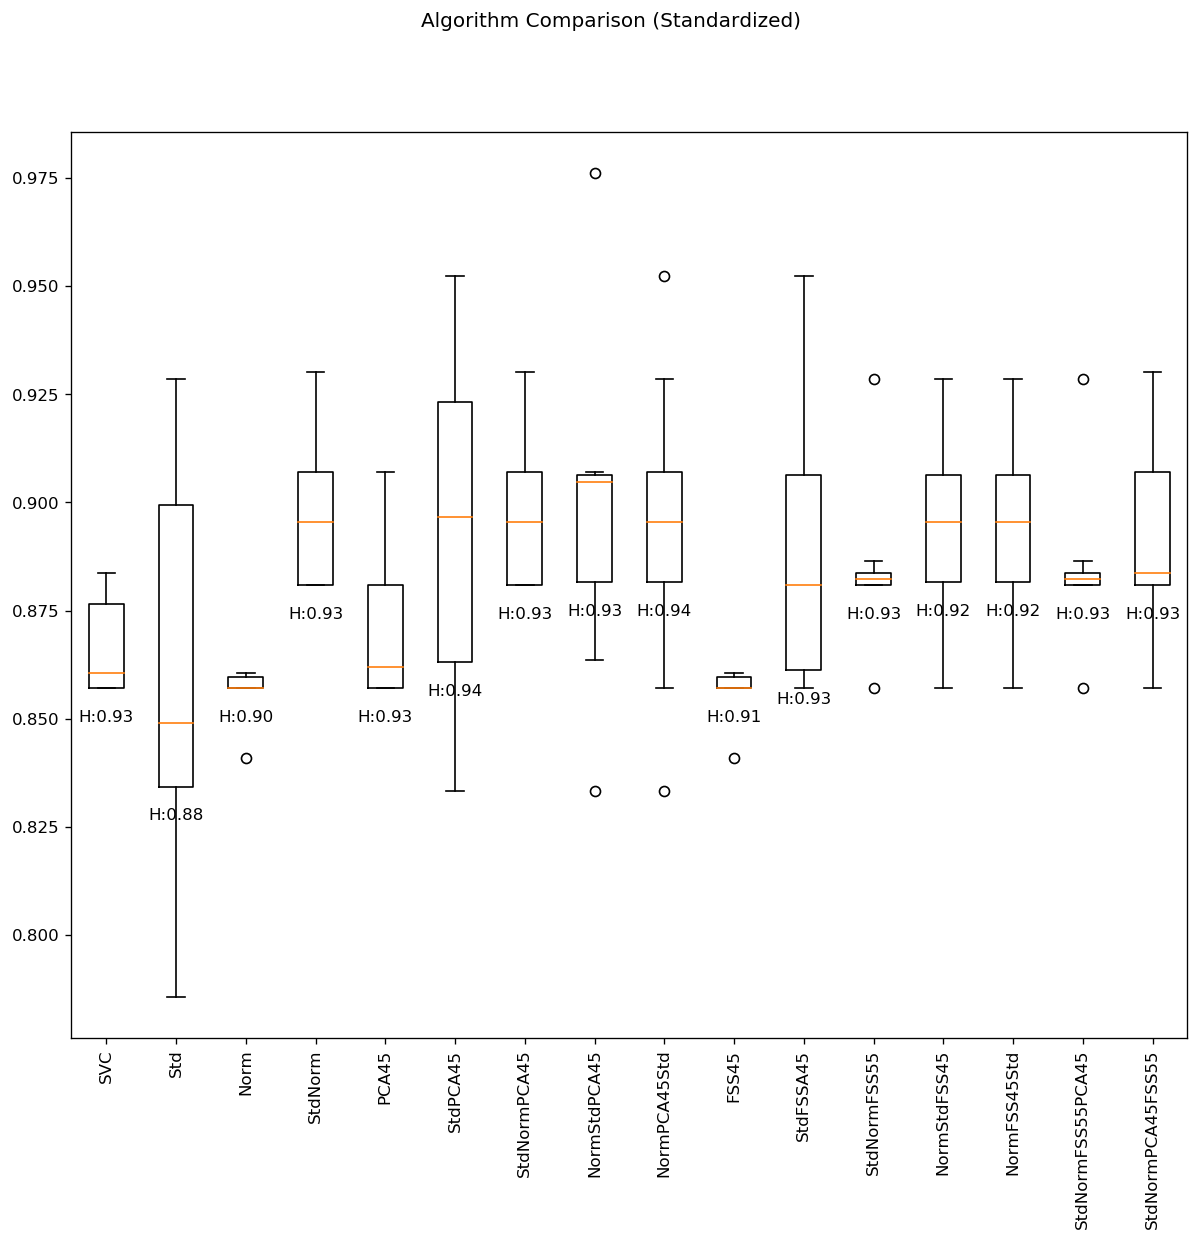

In [23]:
classif = SVC(kernel='linear')

pipelines = []
pipelines.append(('SVC', classif))
pipelines.append(('Std', Pipeline([('Scaler', StandardScaler()),('SVC', classif)])))
pipelines.append(('Norm', Pipeline([('Norm', Normalizer()),('SVC', classif)])))
pipelines.append(('StdNorm', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('SVC', classif)])))

#PCA
pipelines.append(('PCA45', Pipeline([('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdPCA45', Pipeline([('Scaler', StandardScaler()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdNormPCA45', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('NormStdPCA45', Pipeline([('Norm', Normalizer()),('Scaler', StandardScaler()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('NormPCA45Std', Pipeline([('Norm', Normalizer()),('PCA', PCA(n_components=45)),('Scaler', StandardScaler()),('SVC', classif)])))

#FSS
pipelines.append(('FSS45', Pipeline([('FSS', SelectKBest(k=45)),('SVC', classif)])))
pipelines.append(('StdFSSA45', Pipeline([('Scaler', StandardScaler()),('FSS', SelectKBest(k=45)),('SVC', classif)])))


pipelines.append(('StdNormFSS55', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('SVC', classif)])))
pipelines.append(('NormStdFSS45', Pipeline([('Norm', Normalizer()),('Scaler', StandardScaler()),('FSS', SelectKBest(k=55)),('SVC', classif)])))
pipelines.append(('NormFSS45Std', Pipeline([('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('Scaler', StandardScaler()),('SVC', classif)])))

pipelines.append(('StdNormFSS55PCA45', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdNormPCA45FSS55', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=45)),('FSS', SelectKBest(k=25)),('SVC', classif)])))


results = []
names = []
accs = []

for name, model in pipelines:
    kfold = StratifiedKFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train3, Y_train3, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    model.fit(X_train3, Y_train3)

    print("Holdout:")
    predictions = model.predict(X_test3)

    H_acc = accuracy_score(Y_test3, predictions)
    accs.append(H_acc)
    print(H_acc)
    print(confusion_matrix(Y_test3, predictions))
    print(classification_report(Y_test3, predictions))
    print()
    

# Compare Algorithms
fig = plt.figure(figsize=(12, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
fig.suptitle('Algorithm Comparison (Standardized)')
ax = fig.add_subplot(111)
bp_dict = plt.boxplot(results)
ax.set_xticklabels(names)

for idx, line in enumerate(bp_dict['boxes']):
    x, y = line.get_xydata()[0] # bottom of left line
    plt.text(x+.25,y-0.005, 'H:%.2f' % accs[idx],
         horizontalalignment='center', # centered
         verticalalignment='top')

plt.show()

In [24]:
# parameters and ranges to plot
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
    #"PCA__n_components": range(1,115,10)
    #"fss__k" : range(1,115,3)
}

clf = Pipeline([
    ('Norm', Normalizer()),
    ('Scaler', StandardScaler()),
    ("Oversample", RandomOverSampler()),
    #('PCA', PCA()),
    #('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear'))
])

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=20, scoring='f1_micro')

# Tuning hyper-parameters for f1_micro

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   16.6s finished


Best parameters set found on development set:

{'classifier__C': 2.3357214690901213}

Grid scores on development set:

0.306 (+/-0.159) for {'classifier__C': 1.0000000000000001e-05}
0.318 (+/-0.177) for {'classifier__C': 2.06913808111479e-05}
0.572 (+/-0.175) for {'classifier__C': 4.2813323987193957e-05}
0.635 (+/-0.210) for {'classifier__C': 8.8586679041008327e-05}
0.664 (+/-0.234) for {'classifier__C': 0.00018329807108324357}
0.708 (+/-0.190) for {'classifier__C': 0.00037926901907322499}
0.753 (+/-0.203) for {'classifier__C': 0.00078475997035146064}
0.772 (+/-0.190) for {'classifier__C': 0.001623776739188721}
0.786 (+/-0.149) for {'classifier__C': 0.0033598182862837811}
0.812 (+/-0.145) for {'classifier__C': 0.0069519279617756054}
0.819 (+/-0.150) for {'classifier__C': 0.01438449888287663}
0.814 (+/-0.165) for {'classifier__C': 0.029763514416313162}
0.826 (+/-0.163) for {'classifier__C': 0.061584821106602607}
0.812 (+/-0.164) for {'classifier__C': 0.12742749857031321}
0.812 (+/-0.156

## 4. PSP vs PD/MSA

In [25]:
# Get the data
data4 = pd.read_excel('training_data.xlsx')
data4 = group_classes(data4, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=0.35, random_state=42)

SVC: 0.898782 (0.029857)
Holdout:
0.95652173913
[[185   1]
 [  9  35]]
             precision    recall  f1-score   support

          0       0.95      0.99      0.97       186
          1       0.97      0.80      0.88        44

avg / total       0.96      0.96      0.95       230


Std: 0.873145 (0.052697)
Holdout:
0.895652173913
[[171  15]
 [  9  35]]
             precision    recall  f1-score   support

          0       0.95      0.92      0.93       186
          1       0.70      0.80      0.74        44

avg / total       0.90      0.90      0.90       230


Norm: 0.800111 (0.009413)
Holdout:
0.808695652174
[[186   0]
 [ 44   0]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89       186
          1       0.00      0.00      0.00        44

avg / total       0.65      0.81      0.72       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


StdNorm: 0.908250 (0.043963)
Holdout:
0.939130434783
[[183   3]
 [ 11  33]]
             precision    recall  f1-score   support

          0       0.94      0.98      0.96       186
          1       0.92      0.75      0.83        44

avg / total       0.94      0.94      0.94       230


PCA45: 0.898782 (0.029857)
Holdout:
0.95652173913
[[185   1]
 [  9  35]]
             precision    recall  f1-score   support

          0       0.95      0.99      0.97       186
          1       0.97      0.80      0.88        44

avg / total       0.96      0.96      0.95       230


StdPCA45: 0.889480 (0.033412)
Holdout:
0.934782608696
[[176  10]
 [  5  39]]
             precision    recall  f1-score   support

          0       0.97      0.95      0.96       186
          1       0.80      0.89      0.84        44

avg / total       0.94      0.93      0.94       230


StdNormPCA45: 0.910576 (0.042004)
Holdout:
0.939130434783
[[184   2]
 [ 12  32]]
             precision    recall  f1-score   

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

StdFSSA45: 0.884828 (0.042518)
Holdout:
0.926086956522
[[178   8]
 [  9  35]]
             precision    recall  f1-score   support

          0       0.95      0.96      0.95       186
          1       0.81      0.80      0.80        44

avg / total       0.93      0.93      0.93       230


StdNormFSS55: 0.903433 (0.030927)
Holdout:
0.921739130435
[[179   7]
 [ 11  33]]
             precision    recall  f1-score   support

          0       0.94      0.96      0.95       186
          1       0.82      0.75      0.79        44

avg / total       0.92      0.92      0.92       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

NormStdFSS45: 0.898837 (0.029563)
Holdout:
0.930434782609
[[179   7]
 [  9  35]]
             precision    recall  f1-score   support

          0       0.95      0.96      0.96       186
          1       0.83      0.80      0.81        44

avg / total       0.93      0.93      0.93       230


NormFSS45Std: 0.898837 (0.029563)
Holdout:
0.930434782609
[[179   7]
 [  9  35]]
             precision    recall  f1-score   support

          0       0.95      0.96      0.96       186
          1       0.83      0.80      0.81        44

avg / total       0.93      0.93      0.93       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\si

StdNormFSS55PCA45: 0.903433 (0.030927)
Holdout:
0.921739130435
[[179   7]
 [ 11  33]]
             precision    recall  f1-score   support

          0       0.94      0.96      0.95       186
          1       0.82      0.75      0.79        44

avg / total       0.92      0.92      0.92       230


StdNormPCA45FSS55: 0.910465 (0.038027)
Holdout:
0.939130434783
[[184   2]
 [ 12  32]]
             precision    recall  f1-score   support

          0       0.94      0.99      0.96       186
          1       0.94      0.73      0.82        44

avg / total       0.94      0.94      0.94       230




C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


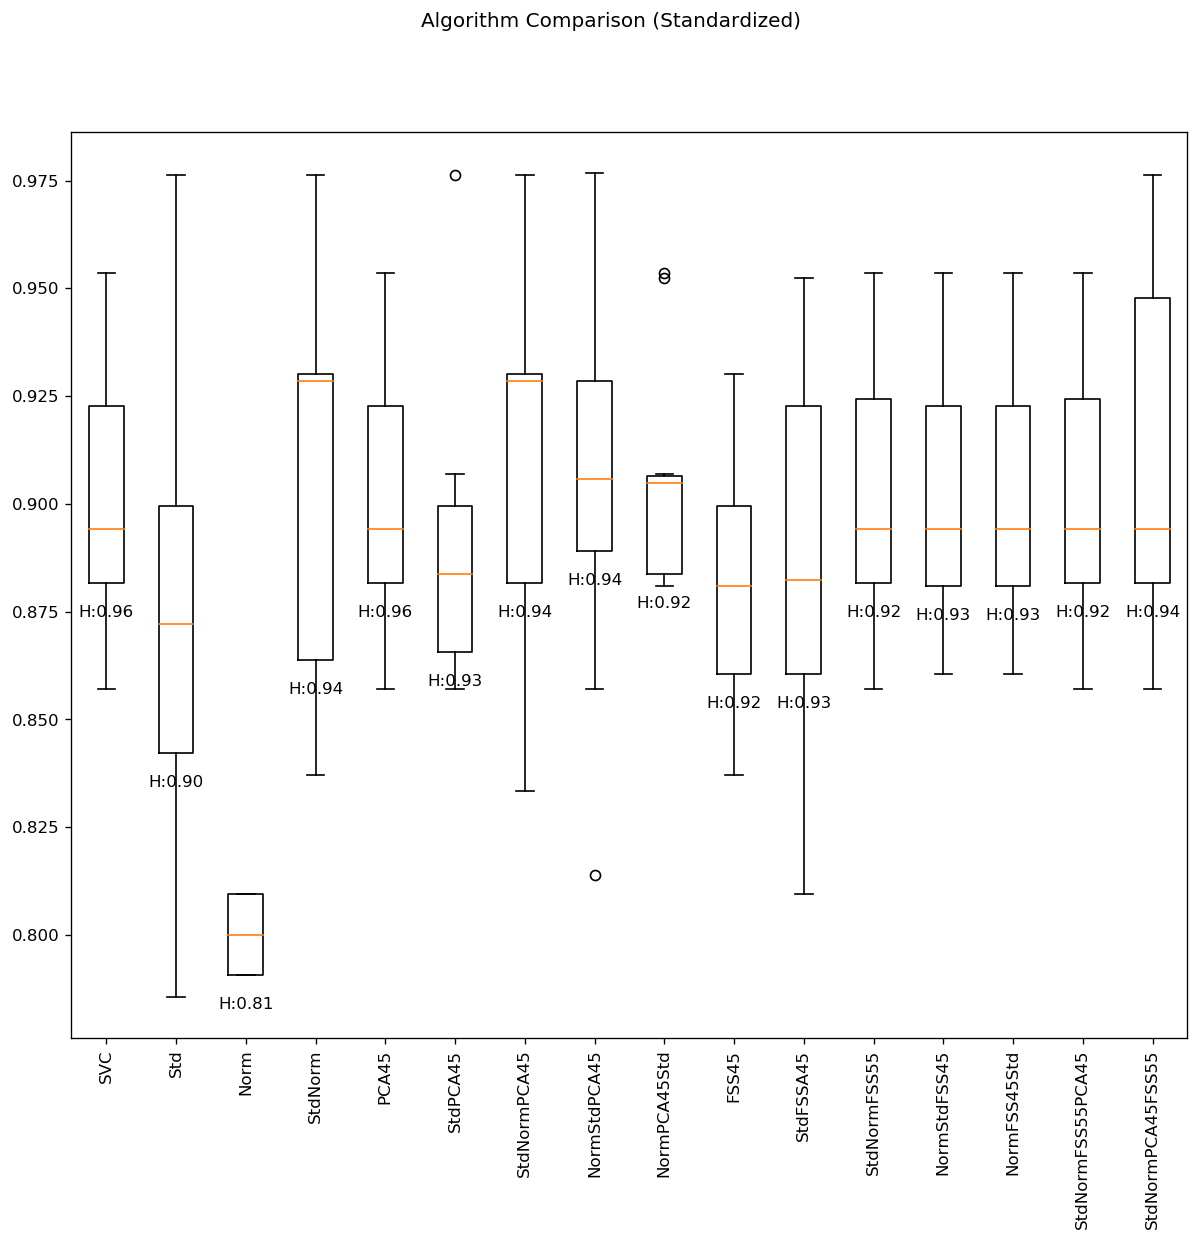

In [26]:
classif = SVC(kernel='linear')

pipelines = []
pipelines.append(('SVC', classif))
pipelines.append(('Std', Pipeline([('Scaler', StandardScaler()),('SVC', classif)])))
pipelines.append(('Norm', Pipeline([('Norm', Normalizer()),('SVC', classif)])))
pipelines.append(('StdNorm', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('SVC', classif)])))

#PCA
pipelines.append(('PCA45', Pipeline([('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdPCA45', Pipeline([('Scaler', StandardScaler()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdNormPCA45', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('NormStdPCA45', Pipeline([('Norm', Normalizer()),('Scaler', StandardScaler()),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('NormPCA45Std', Pipeline([('Norm', Normalizer()),('PCA', PCA(n_components=45)),('Scaler', StandardScaler()),('SVC', classif)])))

#FSS
pipelines.append(('FSS45', Pipeline([('FSS', SelectKBest(k=45)),('SVC', classif)])))
pipelines.append(('StdFSSA45', Pipeline([('Scaler', StandardScaler()),('FSS', SelectKBest(k=45)),('SVC', classif)])))


pipelines.append(('StdNormFSS55', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('SVC', classif)])))
pipelines.append(('NormStdFSS45', Pipeline([('Norm', Normalizer()),('Scaler', StandardScaler()),('FSS', SelectKBest(k=55)),('SVC', classif)])))
pipelines.append(('NormFSS45Std', Pipeline([('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('Scaler', StandardScaler()),('SVC', classif)])))

pipelines.append(('StdNormFSS55PCA45', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('FSS', SelectKBest(k=55)),('PCA', PCA(n_components=45)),('SVC', classif)])))
pipelines.append(('StdNormPCA45FSS55', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=45)),('FSS', SelectKBest(k=25)),('SVC', classif)])))


results = []
names = []
accs = []

for name, model in pipelines:
    kfold = StratifiedKFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train4, Y_train4, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    model.fit(X_train4, Y_train4)

    print("Holdout:")
    predictions = model.predict(X_test4)

    H_acc = accuracy_score(Y_test4, predictions)
    accs.append(H_acc)
    print(H_acc)
    print(confusion_matrix(Y_test4, predictions))
    print(classification_report(Y_test4, predictions))
    print()
    

# Compare Algorithms
fig = plt.figure(figsize=(12, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
fig.suptitle('Algorithm Comparison (Standardized)')
ax = fig.add_subplot(111)
bp_dict = plt.boxplot(results)
ax.set_xticklabels(names)

for idx, line in enumerate(bp_dict['boxes']):
    x, y = line.get_xydata()[0] # bottom of left line
    plt.text(x+.25,y-0.005, 'H:%.2f' % accs[idx],
         horizontalalignment='center', # centered
         verticalalignment='top')

plt.show()

In [27]:
# parameters and ranges to plot
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
    #"PCA__n_components": range(1,115,10)
    #"fss__k" : range(1,115,3)
}

clf = Pipeline([
    ('Norm', Normalizer()),
    ('Scaler', StandardScaler()),
    ("Oversample", RandomOverSampler()),
    #('PCA', PCA()),
    #('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear'))
])

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=20, scoring='f1_micro')

# Tuning hyper-parameters for f1_micro

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 385 out of 400 | elapsed:   12.2s remaining:    0.4s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Grid scores on development set:

0.471 (+/-0.193) for {'classifier__C': 1.0000000000000001e-05}
0.461 (+/-0.222) for {'classifier__C': 2.06913808111479e-05}
0.642 (+/-0.192) for {'classifier__C': 4.2813323987193957e-05}
0.755 (+/-0.235) for {'classifier__C': 8.8586679041008327e-05}
0.814 (+/-0.218) for {'classifier__C': 0.00018329807108324357}
0.821 (+/-0.202) for {'classifier__C': 0.00037926901907322499}
0.838 (+/-0.176) for {'classifier__C': 0.00078475997035146064}
0.849 (+/-0.145) for {'classifier__C': 0.001623776739188721}
0.868 (+/-0.125) for {'classifier__C': 0.0033598182862837811}
0.873 (+/-0.108) for {'classifier__C': 0.0069519279617756054}
0.894 (+/-0.133) for {'classifier__C': 0.01438449888287663}
0.882 (+/-0.135) for {'classifier__C': 0.029763514416313162}
0.882 (+/-0.117) for {'classifier__C': 0.061584821106602607}
0.861 (+/-0.156) for {'classifier__C': 0.12742749857031321}
0.842 (+/-0.14

[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   13.0s finished
